<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/forecast_tickers_Xgboost_exponential_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pmdarima

In [29]:
## Preâmbulo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as qqplot
import random
import yfinance as yf
import os

# bibiotecas Time_series
import matplotlib.dates as mdates
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

import scipy.stats as stats

## importando também o pmdarima, para usar a função auto.arima, que pode otimizar nossos resultados c este tipo de série tempora
import pmdarima as pm

In [30]:
## Estilo do plot:

#plt.style.use([ 'grayscale' , '/content/ativos_csv_2023.csv' ])

In [31]:
df = pd.read_csv('/content/ativos_csv_2023.csv')

df.head()

df.set_index('Date', inplace= True)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')


df.tail()

,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,NMIH,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,41.189999,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,40.830002,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,40.639999,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,40.869999,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04
2024-10-14,3.53,11.38,14.81,17.540001,6.75,31.190001,13.30,2.75,148.990005,192.630005,...,41.000000,10.42,9.88,9.77,20.639999,5.88,19.510000,26.590000,12.62,5.99


In [32]:
## Importando Bitcoin; fazendo join em 'df'

bit_df = yf.download('BTC-USD', start = '2024-01-02')

bit_df = bit_df[['Close']].rename(columns = {'Close':'BTC'})

bit_df.index = pd.to_datetime(bit_df.index, format = '%Y-%m-%d')

df.index = pd.to_datetime(df.index)

df = df.merge(bit_df, left_index=True, right_index=True, how = 'left')

df.tail()

[*********************100%***********************]  1 of 1 completed


,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX,BTC
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96,62131.968750
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87,60582.101562
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04,60274.500000
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04,62445.089844
2024-10-14,3.53,11.38,14.81,17.540001,6.75,31.190001,13.30,2.75,148.990005,192.630005,...,10.42,9.88,9.77,20.639999,5.88,19.510000,26.590000,12.62,5.99,66046.125000


In [33]:
## Definindo o tsplot, como no livro:
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None,xlabel=None,set_major=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if xlabel is not None:
    ax.set_xlabel(xlabel)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  if set_major is not None:
    ax.xaxis.set_major_locator(set_major)
  plt.tight_layout()

  return

In [34]:
avir_df = df[['AVIR']]

avir_df.head()

,AVIR
Date,
2023-01-03,4.81
2023-01-04,4.78
2023-01-05,4.69
2023-01-06,4.70
2023-01-09,4.68


In [35]:
## Fazendo o train-test split (10)

len_df = len(avir_df)
train_size = int(len_df*0.8)

#print(len_df)

train = avir_df.iloc[:train_size]
train.index = pd.to_datetime(train.index)
train = train.asfreq('D', method = 'ffill')

test = avir_df.iloc[train_size:]
test.index = pd.to_datetime(test.index)
test = test.asfreq('D', method = 'ffill')

print(train)
print(test)

            AVIR
Date            
2023-01-03  4.81
2023-01-04  4.78
2023-01-05  4.69
2023-01-06  4.70
2023-01-07  4.70
...          ...
2024-06-01  3.67
2024-06-02  3.67
2024-06-03  3.89
2024-06-04  3.77
2024-06-05  3.96

[520 rows x 1 columns]
            AVIR
Date            
2024-06-06  3.80
2024-06-07  3.70
2024-06-08  3.70
2024-06-09  3.70
2024-06-10  3.79
...          ...
2024-10-10  3.34
2024-10-11  3.48
2024-10-12  3.48
2024-10-13  3.48
2024-10-14  3.53

[131 rows x 1 columns]


In [36]:
avir_df = avir_df.asfreq('D', method = 'ffill')

merged_df = avir_df.copy() #pd.merge(df_final, avir_df, how='left', right_index=True, left_index=True)

merged_df.tail(10)

#merged_df = merged_df.drop('ARIMA', axis = 1)

,AVIR
Date,
2024-10-05,3.46
2024-10-06,3.46
2024-10-07,3.41
2024-10-08,3.41
2024-10-09,3.40
2024-10-10,3.34
2024-10-11,3.48
2024-10-12,3.48
2024-10-13,3.48


In [37]:
## Calculando as Trends
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#from statsmodels.tsa.seasonal import seasonal_decompose

## Estatísticas de ajuste:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def des_optimizer(train, alphas, betas, step=int(len(test))):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_trend=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [38]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 0.5006
alpha: 0.01 beta: 0.11 mae: 1.6327
alpha: 0.01 beta: 0.21 mae: 0.7411
alpha: 0.01 beta: 0.31 mae: 2.345
alpha: 0.01 beta: 0.41 mae: 2.0648
alpha: 0.01 beta: 0.51 mae: 0.6303
alpha: 0.01 beta: 0.61 mae: 2.5634
alpha: 0.01 beta: 0.71 mae: 1.2394
alpha: 0.01 beta: 0.81 mae: 0.991
alpha: 0.01 beta: 0.91 mae: 1.8014
alpha: 0.11 beta: 0.01 mae: 0.2188
alpha: 0.11 beta: 0.11 mae: 0.2438
alpha: 0.11 beta: 0.21 mae: 0.4997
alpha: 0.11 beta: 0.31 mae: 2.1337
alpha: 0.11 beta: 0.41 mae: 3.3561
alpha: 0.11 beta: 0.51 mae: 3.8454
alpha: 0.11 beta: 0.61 mae: 3.762
alpha: 0.11 beta: 0.71 mae: 3.1798
alpha: 0.11 beta: 0.81 mae: 2.7264
alpha: 0.11 beta: 0.91 mae: 2.6363
alpha: 0.21 beta: 0.01 mae: 0.2418
alpha: 0.21 beta: 0.11 mae: 0.6709
alpha: 0.21 beta: 0.21 mae: 2.0488
alpha: 0.21 beta: 0.31 mae: 2.9435
alpha: 0.21 beta: 0.41 mae: 3.3094
alpha: 0.21 beta: 0.51 mae: 3.7142
alpha: 0.21 beta: 0.61 mae: 4.4022
alpha: 0.21 beta: 0.71 mae: 5.2709
alpha: 0.21 beta: 0.81 

<Axes: xlabel='Date'>

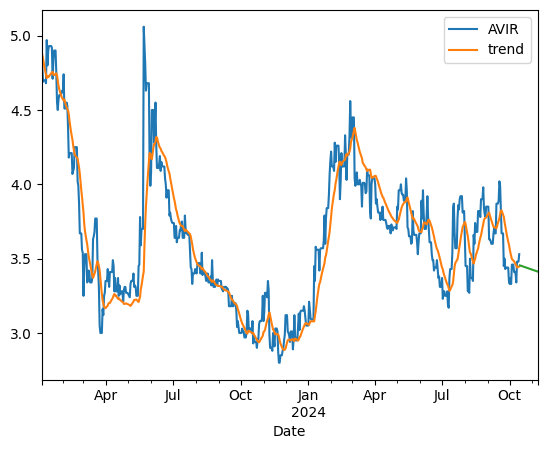

In [39]:
decomp = ExponentialSmoothing(merged_df['AVIR'].dropna(), trend='multiplicative')
fit = decomp.fit(smoothing_level=0.11, smoothing_trend=0.01)
merged_df['trend'] = fit.fittedvalues

fcast = fit.forecast(25)

merged_df[['AVIR','trend']].plot()

fcast.plot()

In [40]:
fcast

,0
2024-10-15,3.454568
2024-10-16,3.452842
2024-10-17,3.451118
2024-10-18,3.449394
2024-10-19,3.447672
2024-10-20,3.445950
2024-10-21,3.444229
2024-10-22,3.442509
2024-10-23,3.440790
2024-10-24,3.439071


In [41]:
fcast.index.name = 'Date'

fcast_df = pd.DataFrame(columns = merged_df.columns, index = fcast.index)
fcast_df['trend'] = fcast.values
fcast_df['AVIR'] = np.nan

fcast_df.head()

,AVIR,trend
Date,,
2024-10-15,NaN,3.454568
2024-10-16,NaN,3.452842
2024-10-17,NaN,3.451118
2024-10-18,NaN,3.449394
2024-10-19,NaN,3.447672


In [42]:
merged_df = pd.concat([merged_df, fcast_df])



In [43]:
## Features 1 - Preços lags

merged_df['lag_3'] = merged_df['AVIR'].shift(3).fillna(method = 'ffill')
merged_df['lag_5'] = merged_df['AVIR'].shift(5)
merged_df['lag_7'] = merged_df['AVIR'].shift(7)
#merged_df['lag_10'] = merged_df['AVIR'].shift(10)
#merged_df['lag_15'] = merged_df['AVIR'].shift(15)
#merged_df['lag_30'] = merged_df['AVIR'].shift(30)


## Criando as Moving averages
# Step 1: Calculate EMAs
merged_df['EMA_9'] = merged_df['AVIR'].ewm(span=9, adjust=False).mean()

# Step 2: Calculate SMAs
merged_df['SMA_5'] = merged_df['AVIR'].rolling(window=5).mean()
merged_df['SMA_15'] = merged_df['AVIR'].rolling(window=15).mean()
merged_df['SMA_30'] = merged_df['AVIR'].rolling(window=30).mean()

# Step 3: Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_df['RSI'] = calculate_rsi(merged_df['AVIR'], window=14)

# Step 4: Calculate MACD
merged_df['EMA_12'] = merged_df['AVIR'].ewm(span=12, adjust=False).mean()
merged_df['EMA_26'] = merged_df['AVIR'].ewm(span=26, adjust=False).mean()
merged_df['MACD'] = merged_df['EMA_12'] - merged_df['EMA_26']
merged_df['MACD_SIGNAL'] = merged_df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line

    ## VAR PERCENTUAL DOS SMAs
pct_5 = merged_df['SMA_5'].dropna().pct_change().iloc[-1]
pct_15 = merged_df['SMA_15'].dropna().pct_change().iloc[-1]
pct_30 = merged_df['SMA_30'].dropna().pct_change().iloc[-1]

for na in range(len(merged_df['SMA_5'].isna())):
    merged_df['SMA_5'] = merged_df['SMA_5'].fillna(merged_df['SMA_5'].shift() * (1 + pct_5))
for na in range(len(merged_df['SMA_15'].isna())):
    merged_df['SMA_15'] = merged_df['SMA_15'].fillna(merged_df['SMA_15'].shift() * (1 + pct_15))
for na in range(len(merged_df['SMA_30'].isna())):
    merged_df['SMA_30'] = merged_df['SMA_30'].fillna(merged_df['SMA_30'].shift() * (1 + pct_30))

merged_df = merged_df.drop(merged_df.index[:14])
merged_df.dropna(subset = 'lag_5', inplace = True)

<ipython-input-43-0c3808e8937e>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['lag_3'] = merged_df['AVIR'].shift(3).fillna(method = 'ffill')


In [44]:
merged_df.tail(15)

,AVIR,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,EMA_12,EMA_26,MACD,MACD_SIGNAL
Date,,,,,,,,,,,,,,
2024-10-05,3.46,3.491799,3.37,3.35,3.44,3.429974,3.390000,3.452000,3.610000,34.328357,3.451610,3.541291,-0.089681,-0.084371
2024-10-06,3.46,3.486720,3.33,3.33,3.44,3.435980,3.416000,3.438000,3.605333,34.328357,3.452901,3.535270,-0.082369,-0.083970
2024-10-07,3.41,3.482171,3.46,3.37,3.35,3.430784,3.424000,3.420667,3.599000,46.000004,3.446301,3.525990,-0.079690,-0.083114
2024-10-08,3.41,3.472549,3.46,3.33,3.33,3.426627,3.440000,3.418000,3.592667,40.000011,3.440716,3.517399,-0.076683,-0.081828
2024-10-09,3.40,3.463920,3.46,3.46,3.37,3.421302,3.428000,3.411333,3.583667,46.153851,3.434452,3.508702,-0.074250,-0.080312
2024-10-10,3.34,3.455074,3.41,3.46,3.33,3.405041,3.404000,3.405333,3.571333,38.636355,3.419921,3.496206,-0.076285,-0.079507
2024-10-11,3.48,3.440484,3.41,3.46,3.46,3.420033,3.408000,3.408000,3.565000,53.448270,3.429164,3.495006,-0.065842,-0.076774
2024-10-12,3.48,3.442940,3.40,3.41,3.46,3.432026,3.422000,3.410667,3.558667,53.448270,3.436985,3.493894,-0.056909,-0.072801
2024-10-13,3.48,3.445166,3.34,3.41,3.46,3.441621,3.436000,3.413333,3.545667,53.448270,3.443603,3.492865,-0.049262,-0.068093


In [45]:
merged_df = merged_df[['AVIR','trend','lag_3','lag_5','lag_7', 'EMA_9','SMA_5','SMA_15','SMA_30','RSI','MACD','MACD_SIGNAL']]

In [46]:
## Separação treino test
train_size = int(len(merged_df)*0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

test_df

,AVIR,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,,
2024-06-13,3.70,3.761358,3.79,3.70,3.80,3.764928,3.778000,3.755333,3.706333,53.488377,0.009656,0.002911
2024-06-14,3.61,3.754955,3.92,3.70,3.70,3.733943,3.760000,3.755333,3.703000,47.727267,-0.003008,0.001727
2024-06-15,3.61,3.739196,3.78,3.79,3.70,3.709154,3.724000,3.751333,3.700000,47.727267,-0.012896,-0.001197
2024-06-16,3.61,3.725029,3.70,3.92,3.70,3.689323,3.662000,3.747333,3.698667,47.727267,-0.020495,-0.005057
2024-06-17,3.53,3.712294,3.61,3.78,3.79,3.657459,3.612000,3.738000,3.694667,34.745761,-0.032598,-0.010565
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,NaN,3.454568,3.48,3.34,3.41,3.459297,3.488197,3.425344,3.523036,69.230766,-0.038721,-0.057519
2024-10-16,NaN,3.452842,3.48,3.48,3.40,3.459297,3.514592,3.431365,3.511775,66.666667,-0.038721,-0.053760
2024-10-17,NaN,3.451118,3.53,3.48,3.34,3.459297,3.541186,3.437397,3.500550,72.727263,-0.038721,-0.050752


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('AVIR', axis=1))
test_scaled = scaler.transform(test_df.drop('AVIR', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop('AVIR', axis=1).columns, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop('AVIR', axis=1).columns, index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['AVIR'] = train_df['AVIR']
test_scaled_df['AVIR'] = test_df['AVIR']

forecast_df = test_scaled_df[test_scaled_df['AVIR'].isna()]

test_scaled_df = test_scaled_df.dropna()

# Split the scaled data into Features and Label
y_train = train_scaled_df['AVIR']
X_train = train_scaled_df.drop('AVIR', axis=1)
y_test = test_scaled_df['AVIR']
X_test = test_scaled_df.drop('AVIR', axis=1)

#forecast_df ; X_forecast, df de forecat do XGBoost
X_forecast = forecast_df.drop('AVIR', axis=1)
X_forecast

In [102]:
X_forecast

,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,
2024-10-15,0.304049,0.300885,0.238938,0.269912,0.287761,0.313726,0.262048,0.316647,0.784260,0.357091,0.333917
2024-10-16,0.303127,0.300885,0.300885,0.265487,0.287761,0.326307,0.265134,0.310399,0.749553,0.357091,0.340762
2024-10-17,0.302205,0.323009,0.300885,0.238938,0.287761,0.338983,0.268225,0.304171,0.831587,0.357091,0.346239
2024-10-18,0.301284,0.323009,0.300885,0.300885,0.287761,0.351755,0.271322,0.297963,0.676781,0.357091,0.350620
2024-10-19,0.300363,0.323009,0.323009,0.300885,0.287761,0.364624,0.274424,0.291774,0.676781,0.357091,0.354125


---

#LSTM

In [ ]:
# Armazenados como Tensores e separados nos conjuntos de Treinamento e Teste como antes. Note a dimensão dos Tensores:

In [52]:
import torch
import torch.nn as nn
from torch.autograd import Variable

Eu preciso definir esses 4 itens através do modelo do Zambon para poder aplicar o modelo do professor

In [ ]:
X_train, y_train, X_test, y_test =

In [70]:
y_train

,AVIR
Date,
2023-01-17,4.92
2023-01-18,4.71
2023-01-19,4.83
2023-01-20,4.90
2023-01-21,4.90
...,...
2024-06-08,3.70
2024-06-09,3.70
2024-06-10,3.79


In [80]:
import pandas as pd

# Assuming 'min' and 'max' are defined beforehand with the desired values
min_val = y_train.min()  # Get the minimum value of y_train
max_val = y_train.max()  # Get the maximum value of y_train

# Use .loc to access elements by index labels and apply the min-max scaling
y_train = (y_train - min_val) / (max_val - min_val)

In [81]:
y_train

,AVIR
Date,
2023-01-17,0.938053
2023-01-18,0.845133
2023-01-19,0.898230
2023-01-20,0.929204
2023-01-21,0.929204
...,...
2024-06-08,0.398230
2024-06-09,0.398230
2024-06-10,0.438053


In [63]:
X_train

,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,
2023-01-17,0.997664,0.942478,0.929204,0.960177,1.000000,1.000000,0.979160,NaN,0.623221,0.469358,0.466937
2023-01-18,1.000000,0.942478,0.942478,0.884956,0.982321,0.979028,0.975743,NaN,0.473019,0.445550,0.468018
2023-01-19,0.989737,0.942478,0.942478,0.929204,0.980149,0.969495,0.977451,NaN,0.622657,0.441368,0.467898
2023-01-20,0.987718,0.938053,0.942478,0.942478,0.985394,0.966635,0.984626,NaN,0.656662,0.446446,0.468998
2023-01-21,0.990126,0.845133,0.942478,0.942478,0.989591,0.963775,0.991459,NaN,0.656662,0.450088,0.470736
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-08,0.456339,0.513274,0.482301,0.384956,0.430279,0.455672,0.404851,0.432772,0.549498,0.418999,0.416614
2024-06-09,0.454102,0.442478,0.429204,0.384956,0.425787,0.448999,0.406218,0.429258,0.549498,0.414084,0.420347
2024-06-10,0.452090,0.398230,0.513274,0.482301,0.431173,0.432793,0.410659,0.427409,0.600465,0.421365,0.425048


In [82]:
min_val = y_test.min()  # Get the minimum value of y_test
max_val = y_test.max()  # Get the maximum value of y_test

# Use .loc to access elements by index labels and apply the min-max scaling
y_test = (y_test - min_val) / (max_val - min_val)

In [83]:
y_test

,AVIR
Date,
2024-06-13,0.623529
2024-06-14,0.517647
2024-06-15,0.517647
2024-06-16,0.517647
2024-06-17,0.423529
...,...
2024-10-10,0.200000
2024-10-11,0.364706
2024-10-12,0.364706


In [65]:
X_test

,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,
2024-06-13,0.468002,0.438053,0.398230,0.442478,0.440209,0.451859,0.431158,0.418347,0.571177,0.431873,0.443949
2024-06-14,0.464581,0.495575,0.398230,0.398230,0.424753,0.443279,0.431158,0.416497,0.493197,0.412296,0.441794
2024-06-15,0.456159,0.433628,0.438053,0.398230,0.412389,0.426120,0.429108,0.414833,0.493197,0.397012,0.436469
2024-06-16,0.448588,0.398230,0.495575,0.398230,0.402497,0.396568,0.427058,0.414093,0.493197,0.385264,0.429441
2024-06-17,0.441782,0.358407,0.433628,0.438053,0.386603,0.372736,0.422275,0.411874,0.317484,0.366556,0.419411
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-10,0.304320,0.269912,0.292035,0.234513,0.260699,0.273594,0.251794,0.343444,0.370145,0.299026,0.293881
2024-10-11,0.296522,0.269912,0.292035,0.292035,0.268177,0.275501,0.253160,0.339930,0.570634,0.315169,0.298857
2024-10-12,0.297835,0.265487,0.269912,0.292035,0.274159,0.282174,0.254527,0.336416,0.570634,0.328976,0.306091


---

In [92]:
#Transformar em Tensores


X_train = torch.tensor(np.array(X_train)).unsqueeze(-1)
X_test = torch.tensor(np.array(X_test)).unsqueeze(-1)
y_train = torch.tensor(np.array(y_train))
y_test = torch.tensor(np.array(y_test))

X_train = X.type(torch.float)
y_train = y.type(torch.float)
X_test = X.type(torch.float)
y_test = y.type(torch.float)


In [89]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)

        h_out = h_out[-1]                         ## saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)
        out_final = self.fc(h_out)

        return out_final

In [90]:
def train(model, optmizer, loss_f, num_epochs, data_train_x, data_train_y):

  for epoch in range(num_epochs):

    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [93]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 ## input size!!! uma única série de dados
hidden_size = 8

for num_layers in range(2,3):

  model = LSTM(input_size, hidden_size, num_layers)

  loss_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, X_train, y_train)

  model.eval()

Epoch: 0, loss: 0.10707
Epoch: 500, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1500, loss: 0.00000


A partir desse ponto eu preciso plotar o gráfico para avaliar o que aconteceu

In [94]:
prediction = model(X)
data_predict = prediction.data.numpy()

# Tentativas malsucedidas do plot:

In [ ]:
y_train

In [130]:
y_test

tensor([[0.3040],
        [0.3031],
        [0.3022],
        [0.3013],
        [0.3004]])

ValueError: x and y must have same first dimension, but have shapes (124,) and torch.Size([5, 1])

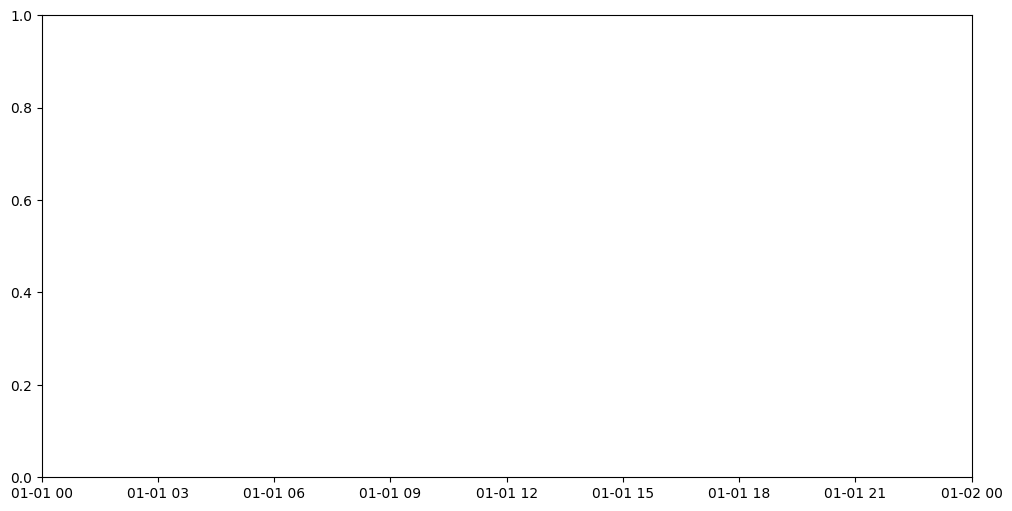

In [ ]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, prediction, color='red', label='Predicted')
plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [96]:
##@markdown
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.plot(y, alpha=0.3, label='Real', color='k')
  plt.plot(y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0 , '0.8, conjunto de treinamento')
  plt.text(300 , 0 , '0.2, de teste')
  plt.legend()
  plt.show()

  return

In [100]:
import matplotlib.pyplot as plt
import torch

def plot_forecast(y, y_pred, X_train, title='Forecasting'):
  """Plots the forecast.

  Args:
    y: The actual values.
    y_pred: The predicted values.
    X_train: The training data.
    title: The title of the plot.
  """

  # Convert y to numpy array and create a range of indices for plotting
  y_np = y.cpu().numpy()  # Move tensor to CPU and convert to numpy
  x_range = range(len(y_np))

  plt.plot(x_range, y_np, alpha=0.3, label='Real', color='k')
  plt.plot(x_range, y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(x_range[0:X_train.shape[0]], y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  # Use len(X_train) instead of X_train.shape[0] and provide x-coordinate directly
  plt.vlines(x=len(X_train), ymin=0, ymax=y_np.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0, '0.8, conjunto de treinamento')
  plt.text(300, 0, '0.2, de teste')
  plt.legend()
  plt.show()

  return

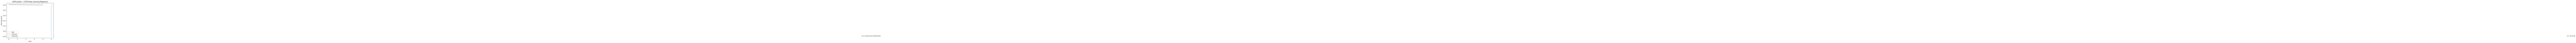

In [101]:
plot_forecast(y_train , y_test, X_train, title='AVIR predict - LSTM Deep Learning Regressor')

tensor([[[0.3009],
         [0.2389],
         [0.2699],
         [0.2878],
         [0.3137],
         [0.2620],
         [0.3166],
         [0.7843],
         [0.3571],
         [0.3339]],

        [[0.3009],
         [0.3009],
         [0.2655],
         [0.2878],
         [0.3263],
         [0.2651],
         [0.3104],
         [0.7496],
         [0.3571],
         [0.3408]],

        [[0.3230],
         [0.3009],
         [0.2389],
         [0.2878],
         [0.3390],
         [0.2682],
         [0.3042],
         [0.8316],
         [0.3571],
         [0.3462]],

        [[0.3230],
         [0.3009],
         [0.3009],
         [0.2878],
         [0.3518],
         [0.2713],
         [0.2980],
         [0.6768],
         [0.3571],
         [0.3506]],

        [[0.3230],
         [0.3230],
         [0.3009],
         [0.2878],
         [0.3646],
         [0.2744],
         [0.2918],
         [0.6768],
         [0.3571],
         [0.3541]]])

ValueError: x and y can be no greater than 2D, but have shapes torch.Size([5, 10, 1]) and torch.Size([5, 1])

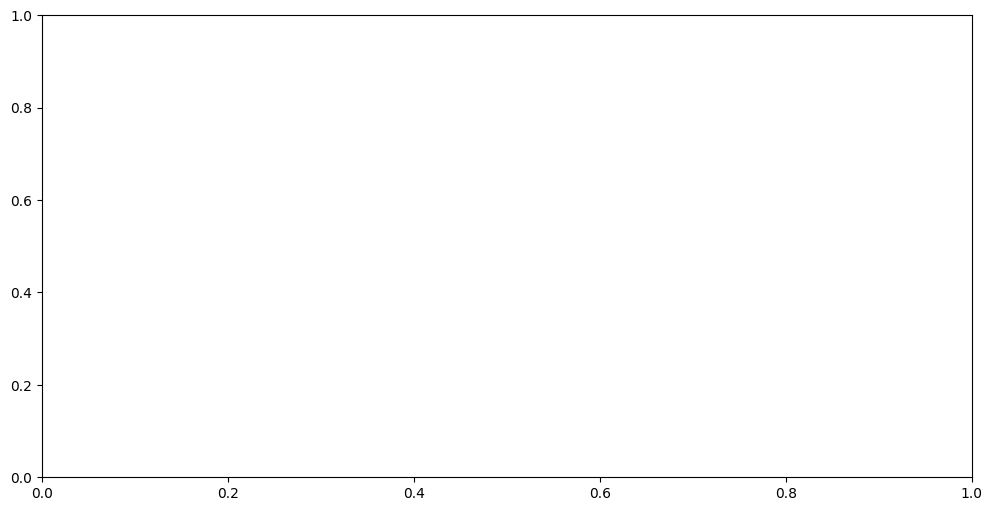

In [110]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(X_test, y_test, label='Real')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [125]:
##@markdown
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.plot(y, alpha=0.3, label='Real', color='k')
  plt.plot(y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0 , '0.8, conjunto de treinamento')
  plt.text(300 , 0 , '0.2, de teste')
  plt.legend()
  plt.show()

  return

In [128]:
import numpy as np
import matplotlib.pyplot as plt

def plot_forecast(y, y_pred, X_train, title='Forecasting'):
    # Converta tensores para arrays, caso necessário
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)

    # Defina os índices de tempo para plotagem
    x_axis = range(len(y))

    # Plotando os valores reais e previstos
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, y, alpha=0.3, label='Real', color='k')
    plt.plot(x_axis, y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

    # Plotando a parte prevista com os dados de treinamento
    plt.plot(x_axis[:X_train.shape[0]], y_pred[:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

    # Marcar a separação entre treinamento e teste
    plt.vlines(x=len(X_train), ymin=y.min(), ymax=y.max(), linestyle='--', color='gray', label='Train/Test Split')

    # Título e rótulos
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Values')

    # Adicionar texto indicando a proporção de treino e teste
    plt.text(len(X_train) * 0.5, y.min() + (y.max() - y.min()) * 0.1, '0.8, conjunto de treinamento')
    plt.text(len(X_train) + len(X_train) * 0.25, y.min() + (y.max() - y.min()) * 0.1, '0.2, conjunto de teste')

    # Adicionar legenda e mostrar o gráfico
    plt.legend()
    plt.show()



ValueError: x and y must have same first dimension, but have shapes (642,) and (5, 1)

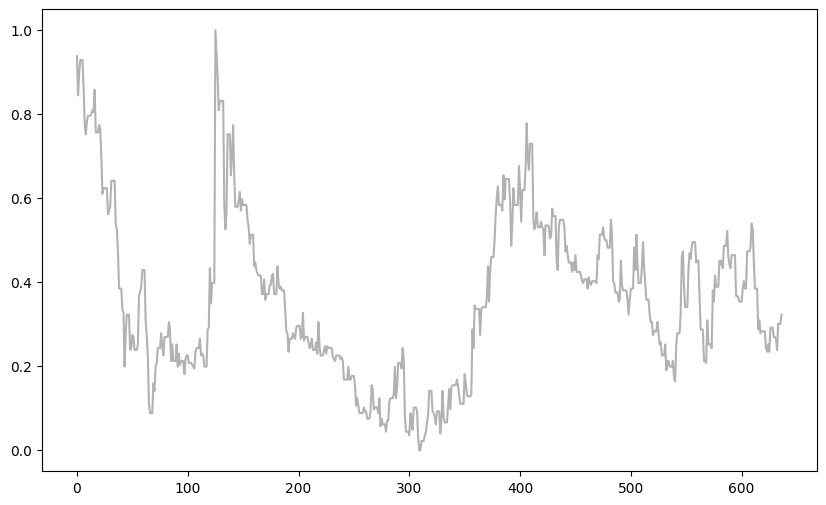

In [129]:
plot_forecast(Y , data_predict, X_train, title='AVIR predict - LSTM Deep Learning Regressor')


#df[['t']] , y = Y
#data_predict, y_pred = data_predict
#X_train = X_train

In [111]:
prediction = model(X)
data_predict = prediction.data.numpy()


In [115]:
Y = merged_df['AVIR']

In [116]:
min_val = Y.min()  # Get the minimum value of Y
max_val = Y.max()  # Get the maximum value of Y

# Use .loc to access elements by index labels and apply the min-max scaling
Y = (Y - min_val) / (max_val - min_val)

In [117]:
Y

,AVIR
Date,
2023-01-17,0.938053
2023-01-18,0.845133
2023-01-19,0.898230
2023-01-20,0.929204
2023-01-21,0.929204
...,...
2024-10-15,NaN
2024-10-16,NaN
2024-10-17,NaN


In [121]:
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.plot(y, alpha=0.3, label='Real', color='k')
  plt.plot(y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0 , '0.8, conjunto de treinamento')
  plt.text(300 , 0 , '0.2, de teste')
  plt.legend()
  plt.show()

  return

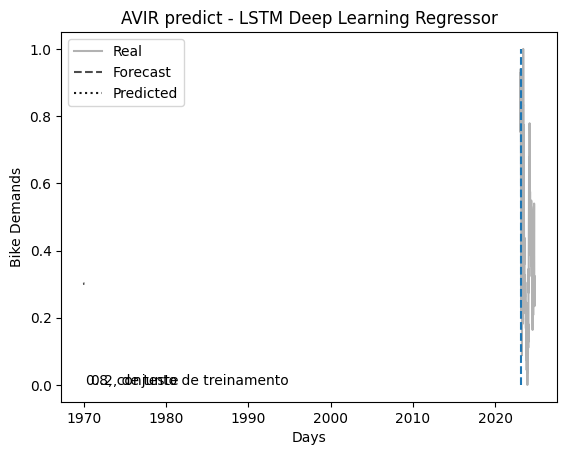

NameError: name 'forecast_accuracy' is not defined

In [123]:
plot_forecast(Y , data_predict, X_train, title='AVIR predict - LSTM Deep Learning Regressor')
#plot_forecast(y, y_pred, X_train, title='AVIR predict - Multivariate MLP (2 Time Series Inputs)')

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1))
dict_metrics['MLPRegressor with 2 input series'] = cur_metrics

In [ ]:
tensor_1d = torch.linspace(0, 10, steps=100)  # 100 pontos entre 0 e 10
tensor_values = torch.sin(tensor_1d)  # Aplicando a função seno para os valores

# Plotando o tensor
plt.plot(tensor_1d.numpy(), tensor_values.numpy())
plt.title('Plot de Tensor 1D usando PyTorch')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y (Seno)')
plt.grid(True)
plt.show()

#XGboost

Continuação original do script Zambon

In [48]:
## Modelo XGBoost
import xgboost as xgb

In [49]:
from sklearn.metrics import make_scorer
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)  # MAPE should be minimized

In [50]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
}

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=1, random_state = 42)
clf = GridSearchCV(model, parameters, scoring={'MAPE': mape_scorer}, refit = 'MAPE', cv=5)

clf.fit(X_train, y_train, verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

KeyboardInterrupt: 

In [ ]:
reg = xgb.XGBRegressor(
    gamma = 0.001,
    learning_rate = 0.05,
    max_depth = 8,
    n_estimators = 300,
    random_state = 42
)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

##

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

In [ ]:
from xgboost import plot_importance

plot_importance(reg)

In [ ]:
y_forecast = reg.predict(X_forecast)

ValueError: x and y must have same first dimension, but have shapes (124,) and torch.Size([5, 1])

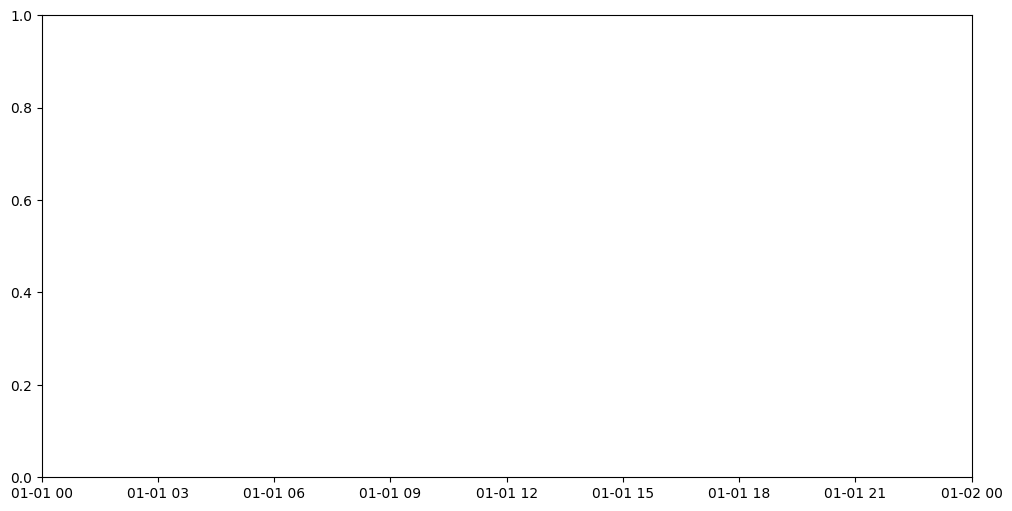

In [105]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
y_pred_train = reg.predict(X_train)

# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train_scaled_df.index, y_train, label='Real')
plt.plot(train_scaled_df.index, y_pred_train, color='red', label='Predicted')
#plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Train Validation')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()